## The Convolutional Neural Network

We will use a convolutional neural network to detect the emotions. 
We will train our model using the FER2013 dataset. Then, using the trained model, we will detect the emotions in the faces detected in the video stream captured by the camera or the video file.


In [53]:
import  tensorflow  as  tf
from  tensorflow  import  keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout


from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

import numpy as  np
import matplotlib.pyplot  as  plt
import os
import cv2
import random


config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

#print the number of GPU

print ( "Num GPUs Available: " ,  len ( tf.config.experimental.list_physical_devices ( 'GPU' )))

Num GPUs Available:  1


2022-11-18 11:15:57.634008: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-18 11:15:57.634245: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-18 11:15:57.634330: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-18 11:15:57.634487: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-18 11:15:57.634577: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from S

# Load the dataset

Load and differentiate between training and testing data (they are spit in two folders, one for training and one for testing).

In [54]:
datadir = "./dataset/"
trainingset = datadir+'train/'
testset = datadir + 'test/'

batch_size = 32


train_data_gen = ImageDataGenerator(                        
                        featurewise_center=False,
                        featurewise_std_normalization=False,
                        rotation_range=10,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        zoom_range=.1,
                        horizontal_flip=True
)
validation_data_gen = ImageDataGenerator(             
                        featurewise_center=False,
                        featurewise_std_normalization=False,
                        rotation_range=10,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        zoom_range=.1,
                        horizontal_flip=True)

train_generator = train_data_gen.flow_from_directory(
        trainingset,
        target_size=(48, 48),
        batch_size=64,
        color_mode="grayscale",
        class_mode='categorical')

# Preprocess all train images
validation_generator = validation_data_gen.flow_from_directory(
        testset,
        target_size=(48, 48),
        batch_size=64,
        color_mode="grayscale",
        class_mode='categorical')

#print the classes
print(train_generator.class_indices)
#reverse the dictionary (key, value) -> (value, key)
classes = dict((v,k) for k,v in train_generator.class_indices.items())
print(classes)








Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
{0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'neutral', 5: 'sad', 6: 'surprise'}


## Train the model

In [55]:
input_shape=(48, 48, 1)
num_classes = 7

def EmotionNet():


    model = keras.Sequential()
    model.add(keras.layers.Convolution2D(filters=16, kernel_size=(7, 7), padding='same',
                                name='image_array', input_shape=input_shape))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Convolution2D(filters=16, kernel_size=(7, 7), padding='same'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation('relu'))
    model.add(keras.layers.AveragePooling2D(pool_size=(2, 2), padding='same'))
    model.add(Dropout(.5))

    model.add(keras.layers.Convolution2D(filters=32, kernel_size=(5, 5), padding='same'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Convolution2D(filters=32, kernel_size=(5, 5), padding='same'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation('relu'))
    model.add(keras.layers.AveragePooling2D(pool_size=(2, 2), padding='same'))
    model.add(Dropout(.5))

    model.add(keras.layers.Convolution2D(filters=64, kernel_size=(3, 3), padding='same'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Convolution2D(filters=64, kernel_size=(3, 3), padding='same'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation('relu'))
    model.add(keras.layers.AveragePooling2D(pool_size=(2, 2), padding='same'))
    model.add(Dropout(.5))

    model.add(keras.layers.Convolution2D(filters=128, kernel_size=(3, 3), padding='same'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Convolution2D(filters=128, kernel_size=(3, 3), padding='same'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation('relu'))
    model.add(keras.layers.AveragePooling2D(pool_size=(2, 2), padding='same'))
    model.add(Dropout(.5))

    model.add(keras.layers.Convolution2D(filters=256, kernel_size=(3, 3), padding='same'))



    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Convolution2D(filters=num_classes, kernel_size=(3, 3), padding='same'))
    model.add(keras.layers.GlobalAveragePooling2D())
    model.add(keras.layers.Activation('softmax',name='predictions'))


    return model
    



                
# create the model
model = EmotionNet()
model.summary()




Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image_array (Conv2D)        (None, 48, 48, 16)        800       
                                                                 
 batch_normalization_25 (Bat  (None, 48, 48, 16)       64        
 chNormalization)                                                
                                                                 
 conv2d_81 (Conv2D)          (None, 48, 48, 16)        12560     
                                                                 
 batch_normalization_26 (Bat  (None, 48, 48, 16)       64        
 chNormalization)                                                
                                                                 
 activation_11 (Activation)  (None, 48, 48, 16)        0         
                                                                 
 average_pooling2d_11 (Avera  (None, 24, 24, 16)     

In [56]:
#train the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_generator, epochs=100, validation_data=validation_generator)





Epoch 1/100
449/449 [==============================] - 11s 24ms/step - loss: 1.7931 - accuracy: 0.2711 - val_loss: 1.8498 - val_accuracy: 0.2254
Epoch 2/100
449/449 [==============================] - 10s 23ms/step - loss: 1.6605 - accuracy: 0.3431 - val_loss: 1.5929 - val_accuracy: 0.3724
Epoch 3/100
449/449 [==============================] - 11s 24ms/step - loss: 1.6021 - accuracy: 0.3708 - val_loss: 1.6175 - val_accuracy: 0.3837
Epoch 4/100
449/449 [==============================] - 11s 25ms/step - loss: 1.5558 - accuracy: 0.3934 - val_loss: 1.4523 - val_accuracy: 0.4390
Epoch 5/100
449/449 [==============================] - 11s 25ms/step - loss: 1.5205 - accuracy: 0.4092 - val_loss: 1.6129 - val_accuracy: 0.3566
Epoch 6/100
449/449 [==============================] - 11s 25ms/step - loss: 1.4856 - accuracy: 0.4270 - val_loss: 1.4493 - val_accuracy: 0.4500
Epoch 7/100
449/449 [==============================] - 11s 25ms/step - loss: 1.4623 - accuracy: 0.4373 - val_loss: 1.4560 - val_ac

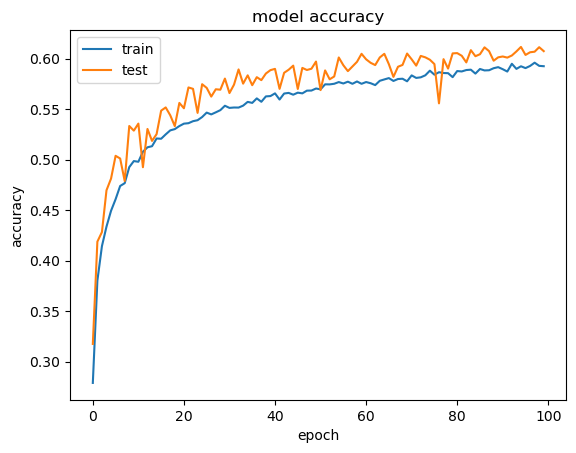

In [ ]:

#plot the accuracy and loss
plt.plot(history.history['accuracy'])

plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')

plt.ylabel('accuracy')

plt.xlabel('epoch')

plt.legend(['train', 'test'], loc='upper left')

plt.show()


In [ ]:
#save the model
model.save('model.h5')


# Setup the application

In [ ]:
#import the module to read from webcam 
import cv2 as cv
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras


classes = {0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'neutral', 5: 'sad', 6: 'surprise'}

The cell below captures a video stream of the camera and displays it in the notebook. The video stream is captured using the OpenCV library. 
If we want to capture from a video file, we can use the following code:

cv.VideoCapture('project_video.mp4')

On the other hand, if we want to use the camera, we can use the following code:

cv.VideoCapture(0)


In [ ]:
videoPath = "METTERE QUI IL PATH DEL VIDEO"

if videoPath == "METTERE QUI IL PATH DEL VIDEO" or videoPath == "":
    cap = cv.VideoCapture(0)
else:
    cap = cv.VideoCapture(videoPath)
    


Below, we will choose if we want to dected the frontal faces, the profile or both. We will use the frontal face cascade classifier by default.

In [ ]:
haarDetectionMode = "profile"

In [ ]:
haarDetectionMode = "profileAndFrontal"

In [ ]:
haarDetectionMode = "frontal"

In [ ]:
saveCroppedFaces = False
predictEmotions = True

The function detect faces uses haar cascade to detect faces in the frame. 
There are two versions of haar cascades, one for profile faces and one for frontal faces.



In [ ]:
def detectFaces(frame):

    detectedFaces = []


    #use haar cascade to detect faces
    if haarDetectionMode == "frontal" or haarDetectionMode == "profileAndFrontal":
        faceCascadeFrontal = cv.CascadeClassifier(cv.data.haarcascades + 'haarcascade_frontalface_default.xml')
        facesFrontal = faceCascadeFrontal.detectMultiScale(frame, 1.1, 4)

        detectedFaces.extend(facesFrontal)

    elif haarDetectionMode == "profile" or haarDetectionMode == "profileAndFrontal":
        faceCascadeProfile = cv.CascadeClassifier(cv.data.haarcascades + 'haarcascade_profileface.xml')
        facesProfile = faceCascadeProfile.detectMultiScale(frame, 1.1, 4)

        detectedFaces.extend(facesProfile)




    

    return detectedFaces

In [ ]:
def drawRectangleFace(frame, facesCoordinates):
    #draw the rectangle around the face
    frameWithRectangle = frame.copy()
    for (x, y, w, h) in facesCoordinates:
        cv.rectangle(frameWithRectangle, (x, y), (x+w, y+h), (255, 0, 0), 2)
        
    return frameWithRectangle
        
        
    
        

In [ ]:
def plotImage(image):
    plt.imshow(image)
    plt.show()

In [ ]:
def predictEmotion(face):
    #resize the image
    face = cv.resize(face, (48, 48))

    #convert the image to float
    face = face.astype('float32')
    #normalize the image
    face /= 255
    #reshape the image
    face = face.reshape(1, 48, 48, 1)
    #predict the emotion
    emotion = model.predict(face)
    return emotion

In [ ]:
if predictEmotions:
    #load the model
    model = keras.models.load_model('model.h5')
    

In [ ]:
def writeEmotionOnImage(frame, facesCoordinates, emotions):
    frameWithEmotion = frame.copy()
    for (x, y, w, h), emotion in zip(facesCoordinates, emotions):
        #get the emotion with the highest probability
        emotion = np.argmax(emotion)
        #get the emotion label
        emotionLabel = classes[emotion]
        #write the emotion label on the image
        cv.putText(frameWithEmotion, emotionLabel, (x, y), cv.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv.LINE_AA)
    return frameWithEmotion

In [ ]:

def showVideo():
    ret,frame = cap.read()

    if not ret:
        print("Unable to capture video")
        exit()
        
    
    #flip the image
    frame = cv.flip(frame,1)
    grayFrame = frame
    #convert the image to grayscale
    if frame is not None:
        grayFrame = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)

    

    #detect the face
    facesCoordinates = detectFaces(grayFrame)

    #draw the rectangle around the face
    frameToShow = drawRectangleFace(frame, facesCoordinates)

    if predictEmotions:

        emotions = []
        for (x, y, w, h) in facesCoordinates:
            #crop the face
            face = grayFrame[y:y+h, x:x+w]
            face = cv.resize(face, (48, 48))

            #face to grayscale

            #predict the emotion
            emotion = predictEmotion(face)
            emotions.append(emotion)
            

        frameToShow = writeEmotionOnImage(frameToShow, facesCoordinates, emotions)


    #display the image
    cv.imshow('frame',frameToShow)
    ret = True
    if cv.waitKey(1) & 0xFF == ord('q'):
        ret = False
        
    return ret, frame, facesCoordinates

In [ ]:
ret = True
while ret:
    
    

    #show the video with the face detected
    ret, frame, facesCoordinates = showVideo()


    if saveCroppedFaces:
        cv.imwrite(".\\detectedFaces\\face" + str(x) + str(y) + ".jpg", crop_img)

                
            
    
#release the camera
cap.release()
#close all windows
cv.destroyAllWindows()

1/1 [==============================] - 0s 16ms/step
